# Индивидуальное задание №1

## Задание 1

Сделать изображение на телефон или фотоаппарат. Из-за неидеальности цифровой техники, на нём получатся искажения. Попытаться улучшить полученное изображение с помощью изученных методов. В отчёте пояснить, почему выбрали именно эти методы.

In [1]:
import cv2
import numpy as np
import skimage
import skimage.io
from matplotlib import pyplot as plt

src_image_url = 'https://drive.google.com/u/0/uc?id=1SIIhgwBv4g3Wj12dtWdeLuyqIrS8kmi8&export=download'

src_image = skimage.io.imread(src_image_url)
r = src_image[:,:,0].astype(np.float64) / 255
g = src_image[:,:,1].astype(np.float64) / 255
b = src_image[:,:,2].astype(np.float64) / 255

Первое, что бросается в глаза - общая "мыльность" картинки. Чтобы сделать ее более резкой, воспользусь методом Люси-Ричардсона.

In [2]:
psf = np.ones((9, 9)) / (9 * 9)
deconv_r = skimage.restoration.richardson_lucy(r, psf)
deconv_g = skimage.restoration.richardson_lucy(g, psf)
deconv_b = skimage.restoration.richardson_lucy(b, psf)
deconv_image = np.dstack([deconv_r, deconv_g, deconv_b])

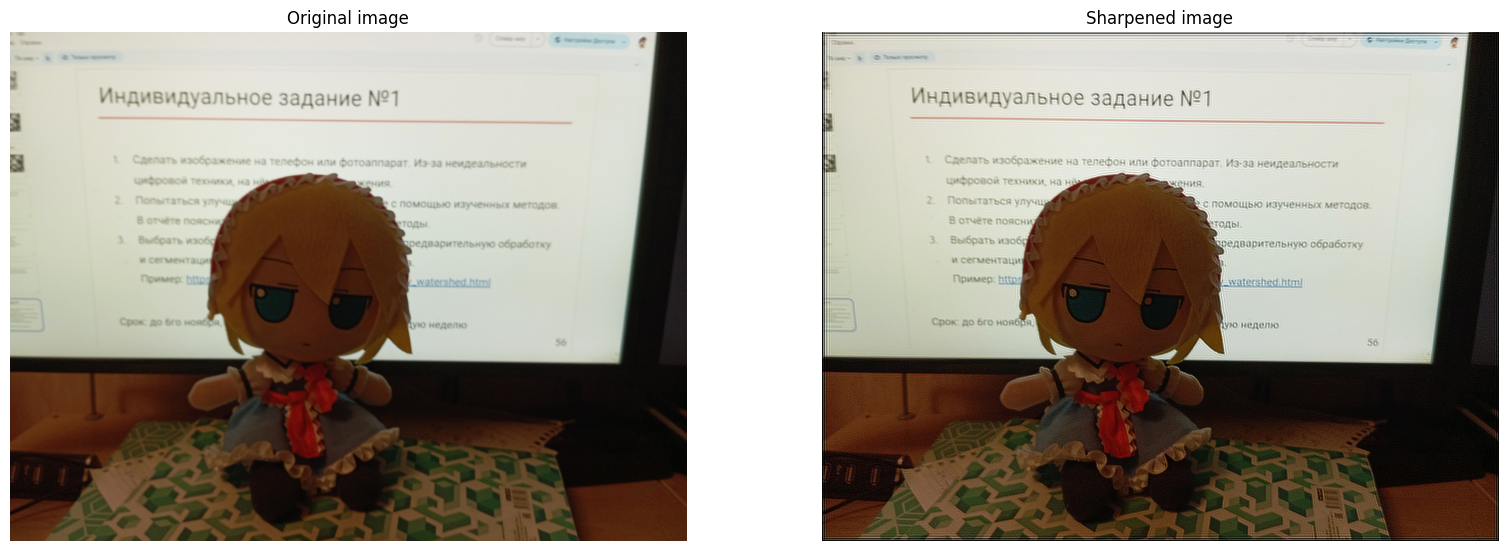

In [3]:
plt.figure(figsize=[6.4 * 2 * 1.5, 4.8 * 1.5])
plt.subplot(1, 2, 1)
plt.imshow(src_image)
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(deconv_image)
plt.axis("off")
plt.title("Sharpened image");

Далее, можно заметить, что фумо (кукла на переднем плане) довольно темная на фоне яркого экрана монитора. Использовав пороговое сегментирование, я смогу получить две группы пикселей - темные и светлые. Осветлю темные скалированием, чтобы слишком темные пиксели не получили большой прирост в яркости.

In [4]:
r = deconv_image[:,:,0]
g = deconv_image[:,:,1]
b = deconv_image[:,:,2]

thr_r = cv2.threshold((r * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] == 0
thr_g = cv2.threshold((g * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] == 0
thr_b = cv2.threshold((b * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] == 0

gain = 1.5

new_r = r.copy()
new_g = g.copy()
new_b = b.copy()
new_r[thr_r] *= gain
new_g[thr_g] *= gain
new_b[thr_b] *= gain

brightened_image = np.dstack([new_r, new_g, new_b])

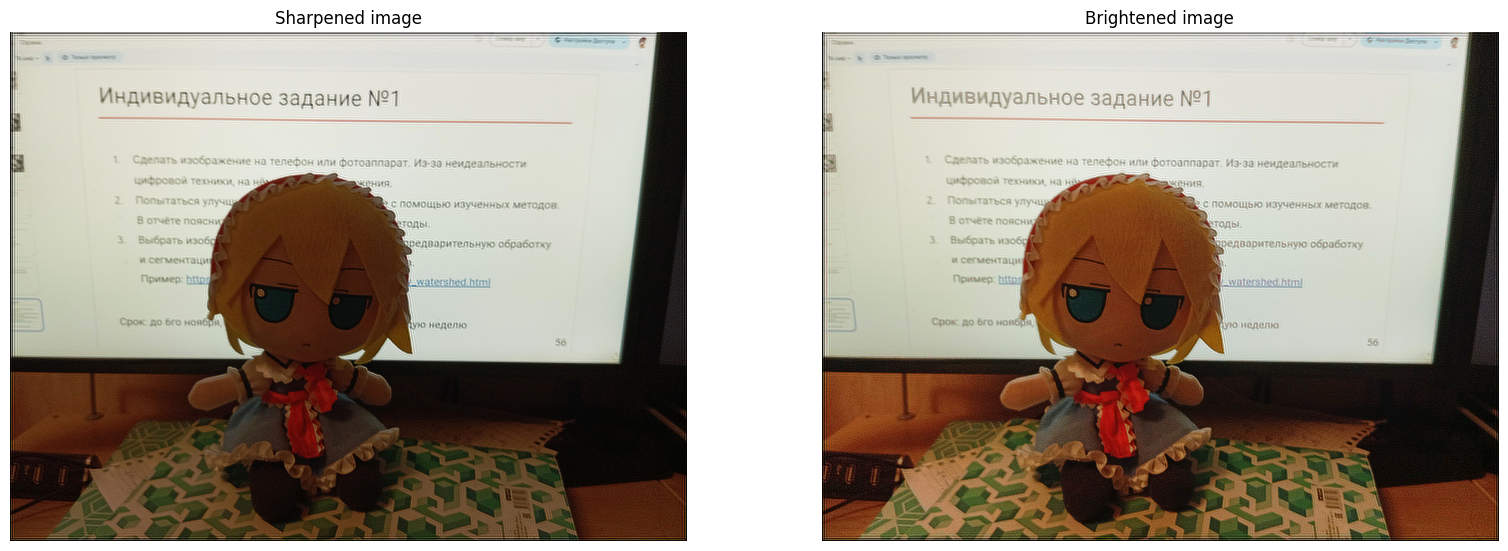

In [5]:
plt.figure(figsize=[6.4 * 2 * 1.5, 4.8 * 1.5])
plt.subplot(1, 2, 1)
plt.imshow(deconv_image)
plt.axis("off")
plt.title("Sharpened image")

plt.subplot(1, 2, 2)
plt.imshow(brightened_image)
plt.axis("off")
plt.title("Brightened image");

Вроде получилось неплохо :)

## Задание 2

Выбрать изображение для сегментации. Провести предварительную обработку и сегментацию изображения методом водоразделов. 
Пример: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

In [6]:
src_image_url = 'https://drive.google.com/u/0/uc?id=1EwWfkJJBE20BXb-ysyBuCOuhFnMZeAeb&export=download'
src_image = skimage.io.imread(src_image_url)
gray_image = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)

In [7]:
thresh = cv2.threshold((gray_image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=2)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)[1]

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

markers = cv2.connectedComponents(sure_fg)[1]
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(src_image, markers)

img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
img[markers == -1] = [255, 0, 0]

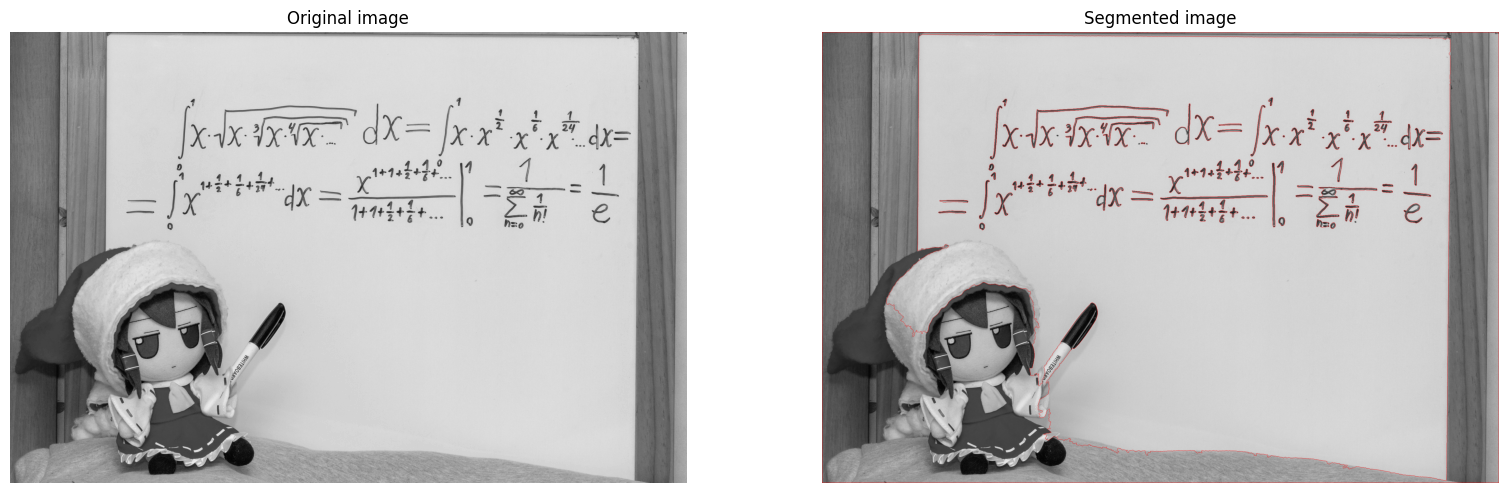

In [8]:
plt.figure(figsize=[6.4 * 2 * 1.5, 4.8 * 1.5])
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.axis("off")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis("off")
plt.title("Segmented image");

### Выполнил: Лежнин Максим Витальевич